# Imports

In [41]:
from scipy.stats import truncnorm, multivariate_normal, norm
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import pandas as pd
import os

# Hyperparameters

In [42]:
dataset_path = "SerieA.csv" #"Extension_data.csv"
mu_1 = 25
mu_2 = 25
sigma_1 = 25/3
sigma_2 = 25/3
sigma_t = 25/6
iterations = 1200
burn_in = 25 # Q4, 
num_seeds = 42 # for Q5.2, changing the order of the matches.\
predict_epsilon = 0.02 # considering draws
t_epsilon = sigma_t/4 # considering draws

# Q4 - Gibbs sampler

## Gibbs sampler

In [43]:
# sample from a truncated normal distribution
def truncated_normal(mean, std, lower, upper):
    a, b = (lower - mean) / std, (upper - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std)

# Gibbs Sampler
def gibbs_sampler(mu_A, sigma_A, mu_B, sigma_B ,y, iterations):
    
    if y == 1:
        t = np.abs(np.random.randn())
    else:
        t = -np.abs(np.random.randn())

    
    samples = []
    
    for i in range(iterations):
        # Calculationg mean and sigma of p(s1,s2|t,y) = p(S|t,y)
        
        sigma_s_inv = np.array([[1.0/(sigma_A * sigma_A), 0.0],
                                [0.0, 1.0/(sigma_B * sigma_B)]])
        
        sigma_t_given_s_inv = 1.0 / (sigma_t * sigma_t)
        mu_s = np.array([mu_A, mu_B]).T.reshape(2,1) # 2 x 1 (2, 1)
        A = np.array([1.0, -1.0]).reshape(1, 2) # 1 x 2
        
        # (2x2)
        cov_s_given_t = np.linalg.inv(sigma_s_inv + (A.T @ (sigma_t_given_s_inv * A) ) )
        
        # (2x1)
        mean_s_given_t = cov_s_given_t @ ( (sigma_s_inv @ mu_s) + (A.T * sigma_t_given_s_inv * t) )
 
       
        
        mean_s_given_t = mean_s_given_t.reshape(2,)
        # QUESTION 3.1
        # Step 1: Draw s_1 and s_2 from the conditional distribution N(mean_s|t, cov_s|t) -
        s_1, s_2 = multivariate_normal.rvs(mean=mean_s_given_t, cov=cov_s_given_t)

        

        # QUESTION 3.2
        # Step 2: Draw t from the conditional distribution 
        mean_t = s_1 - s_2 
        if y == 1:
            t = truncated_normal(mean_t, sigma_t, 0, np.inf)  # For y = 1, t > 0
        else:
            t = truncated_normal(mean_t, sigma_t, -np.inf, 0)  # For y = -1, t < 0

        # Store samples
        samples.append((s_1, s_2, t))

    
  
    samples = np.array(samples)
    return samples

## Q4.1

In [44]:
# Example execution of the sampler for y = 1
samples = gibbs_sampler(mu_1, sigma_1, mu_2, sigma_2, y=1, iterations=iterations)

# Extract samples s_1, s_2, and t 
s_1_samples, s_2_samples, t_samples = samples[:, 0], samples[:, 1], samples[:, 2]

print(f"Samples shape: {samples.shape}, First sample (s_1, s_2, t): {samples[0]}")
print(f"s_1 shape: {s_1_samples.shape}, s_2 shape: {s_2_samples.shape}, t shape: {t_samples.shape}")


Samples shape: (1200, 3), First sample (s_1, s_2, t): [33.82492799 22.00323332  7.91638624]
s_1 shape: (1200,), s_2 shape: (1200,), t shape: (1200,)


### Trace Plot $before$ Burn-in 

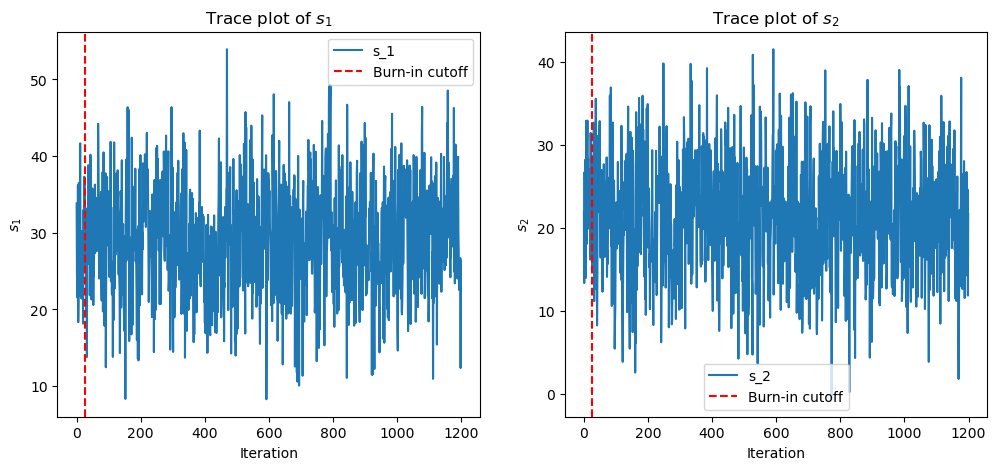

In [45]:
# Trace plots to determine the burn-in period
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(s_1_samples, label="s_1")
plt.axvline(x=burn_in, color='r', linestyle='--', label='Burn-in cutoff')
plt.title("Trace plot of $s_1$")
plt.xlabel("Iteration")
plt.ylabel("$s_1$")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(s_2_samples, label="s_2")
plt.axvline(x=burn_in, color='r', linestyle='--', label='Burn-in cutoff')
plt.title("Trace plot of $s_2$")
plt.xlabel("Iteration")
plt.ylabel("$s_2$")
plt.legend()
plt.show()

### TRACE PLOT $AFTER$ BURN IN

In [46]:
s_1_filtered = s_1_samples[burn_in:]
s_2_filtered = s_2_samples[burn_in:]

skills_filtered = np.column_stack((s_1_filtered, s_2_filtered)) # shape: (n_samples, 2)

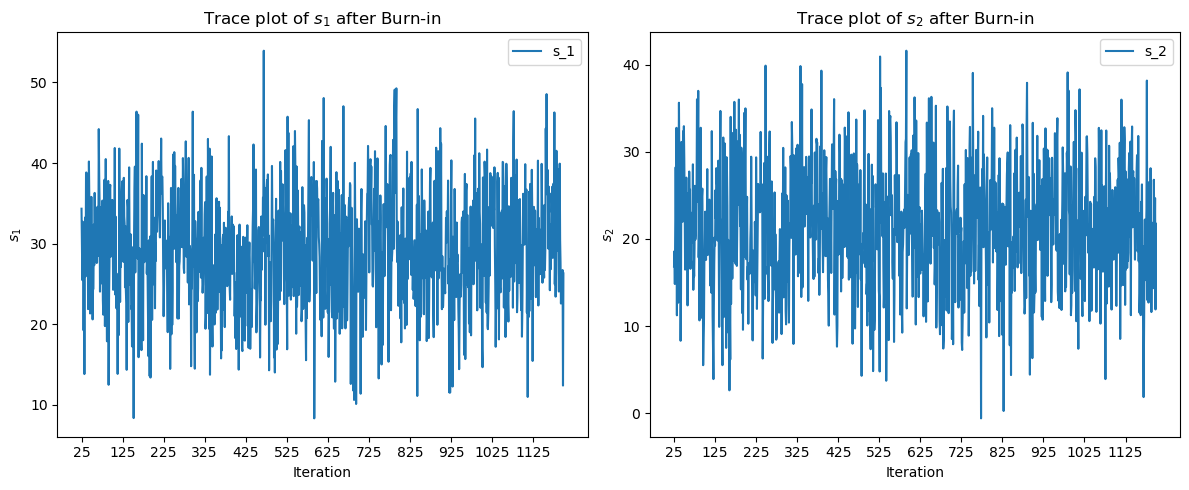

In [47]:
# Trace plots to show iterations after burn-in period
plt.figure(figsize=(12, 5))

# Plot for s_1 after burn-in
plt.subplot(1, 2, 1)
plt.plot(s_1_filtered, label="s_1")  # Plotting from burn_in onwards
plt.title("Trace plot of $s_1$ after Burn-in")
plt.xlabel("Iteration")
plt.ylabel("$s_1$")
step_size = 100  # Adjust the step size for readability
plt.xticks(ticks=np.arange(0, len(s_1_filtered), step=step_size), 
           labels=np.arange(burn_in, burn_in + len(s_1_filtered), step=step_size))
plt.legend()

# Plot for s_2 after burn-in
plt.subplot(1, 2, 2)
plt.plot(s_2_filtered, label="s_2")  # Plotting from burn_in onwards
plt.title("Trace plot of $s_2$ after Burn-in")
plt.xlabel("Iteration")
plt.ylabel("$s_2$")
plt.xticks(ticks=np.arange(0, len(s_2_filtered), step=step_size), 
           labels=np.arange(burn_in, burn_in + len(s_2_filtered), step=step_size))
plt.legend()

plt.tight_layout()
plt.show()


## Q4.2

Approximate samples by a multivariate normal distibution

In [48]:
def gaussian_approximation(samples):
    mean = np.mean(samples, axis = 0)
    covariance = np.cov(samples, rowvar = False) # rowvar=False ensures we calculate cov among players (columns)
    # Creating a multivariate normal distribution object
    gaussian_dist = multivariate_normal(mean=mean, cov=covariance)
    return gaussian_dist

gaussian_dist = gaussian_approximation(skills_filtered)


# Print the mean and covariance of the approximated Gaussian distribution
print("Mean of the approximated Gaussian distribution:", gaussian_dist.mean)
print("Covariance matrix of the approximated Gaussian distribution:", gaussian_dist.cov)

Mean of the approximated Gaussian distribution: [29.22907565 21.33489714]
Covariance matrix of the approximated Gaussian distribution: [[49.80306694 23.52988681]
 [23.52988681 48.33531141]]


## Q4.3

Plot Function - Gaussian Approximation and Histograms for Samples from Gibbs Sampler

In [49]:
# Function to generate the plot layout for each sample size
def plot_gaussian_with_histograms(ax_contour, ax_histx, ax_histy, samples, num_samples, elapsed_time):
    # Extract the range of s1 and s2
    s1_min, s1_max = np.min(samples[:, 0]), np.max(samples[:, 0])
    s2_min, s2_max = np.min(samples[:, 1]), np.max(samples[:, 1])

    # Set limits for the contour plot based on the data range
    ax_contour.set_xlim(s1_min, s1_max)
    ax_contour.set_ylim(s2_min, s2_max)

    # Create a grid for the 2D distribution based on the data range
    x, y = np.mgrid[s1_min:s1_max:100j, s2_min:s2_max:100j]  # Adjust grid range
    pos = np.dstack((x, y))

    # Fit the multivariate Gaussian to your data (optional, depends on what you're doing)
    gaussian_dist = gaussian_approximation(samples)

    # Plot the 2D contour plot using the Gaussian approximation
    ax_contour.contourf(x, y, gaussian_dist.pdf(pos), cmap='Blues')
    ax_contour.scatter(samples[:, 0], samples[:, 1], s=5, color='r', alpha=0.5, label="Samples")
    ax_contour.set_xlabel('s1')
    ax_contour.set_ylabel('s2')
    ax_contour.set_title(f'{num_samples} samples, Time: {elapsed_time:.2f} sec')

    # Plot the histogram for s1 (top)
    ax_histx.hist(samples[:, 0], bins=30, density=True, alpha=0.6, color='g', label="Histogram (s1)")
    x_vals = np.linspace(s1_min, s1_max, 100)
    ax_histx.plot(x_vals, norm.pdf(x_vals, gaussian_dist.mean[0], np.sqrt(gaussian_dist.cov[0, 0])), 'g-', lw=2, label="Gaussian fit (s1)")
    ax_histx.set_xlim(s1_min, s1_max)  # Set x-axis limits for s1 histogram
    ax_histx.set_ylabel('Density')

    # Plot the histogram for s2 (right)
    ax_histy.hist(samples[:, 1], bins=30, density=True, orientation='horizontal', alpha=0.6, color='b', label="Histogram (s2)")
    y_vals = np.linspace(s2_min, s2_max, 100)
    ax_histy.plot(norm.pdf(y_vals, gaussian_dist.mean[1], np.sqrt(gaussian_dist.cov[1, 1])), y_vals, 'purple', lw=2, label="Gaussian fit (s2)")
    ax_histy.set_ylim(s2_min, s2_max)  # Set y-axis limits for s2 histogram
    ax_histy.set_xlabel('Density')

Plot for 4 different sample_sizes

Sample Size: 200
Mean of the approximated Gaussian distribution: [29.45046981 20.36464639]
Covariance matrix of the approximated Gaussian distribution: [[45.20908155 21.06691635]
 [21.06691635 49.15909576]]

Sample Size: 800
Mean of the approximated Gaussian distribution: [29.55355097 20.8082264 ]
Covariance matrix of the approximated Gaussian distribution: [[54.90529988 20.87776926]
 [20.87776926 49.49361461]]

Sample Size: 1200
Mean of the approximated Gaussian distribution: [29.10113524 20.8420292 ]
Covariance matrix of the approximated Gaussian distribution: [[48.3368738  20.49439652]
 [20.49439652 43.58606195]]

Sample Size: 3000
Mean of the approximated Gaussian distribution: [29.38342902 20.77476683]
Covariance matrix of the approximated Gaussian distribution: [[48.35266326 19.39500367]
 [19.39500367 47.11990783]]



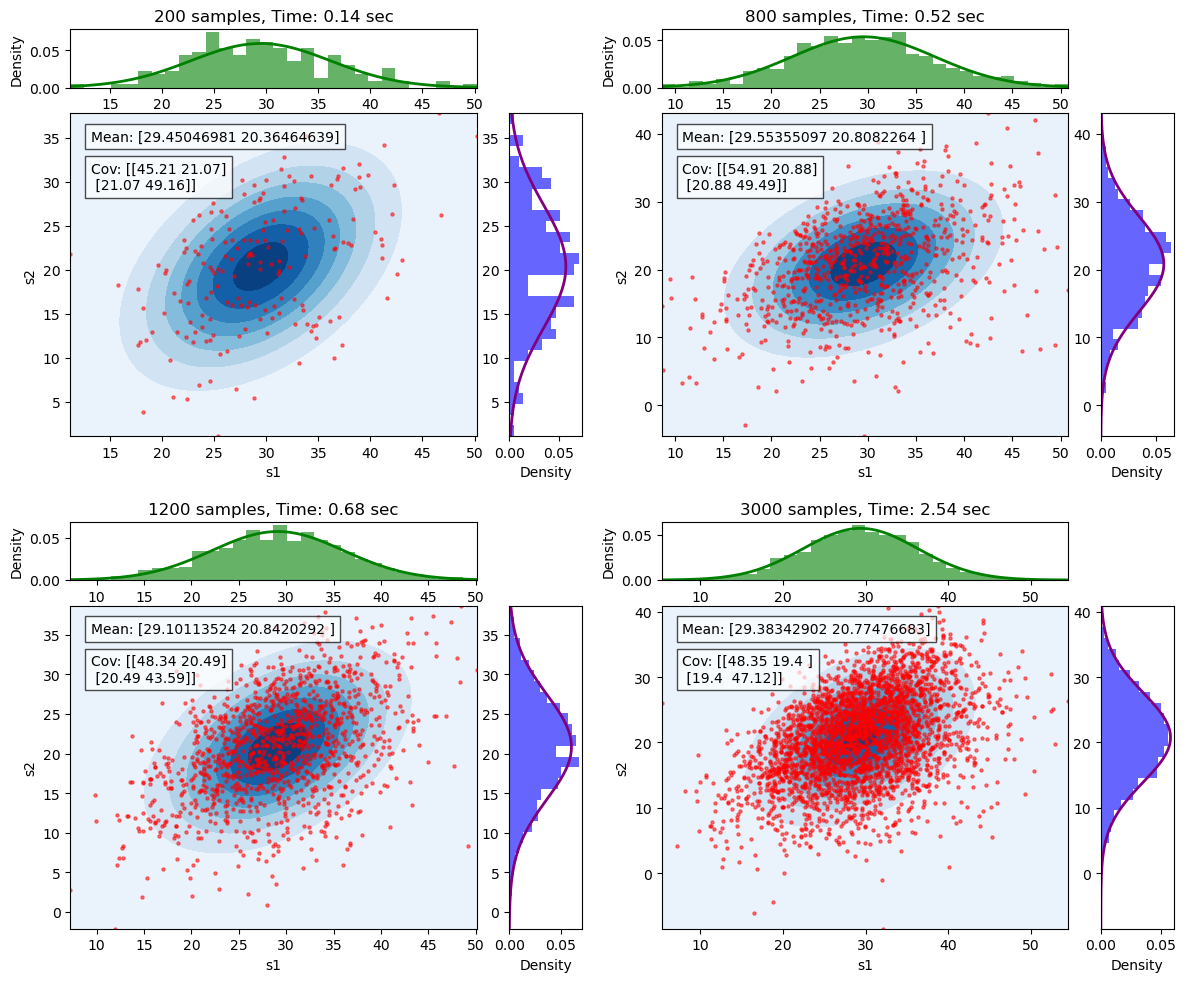

In [50]:
sample_sizes = [200, 800, 1200, 3000]
# sample_sizes = [iterations * i for i in range(1, 5)]
#sample_sizes = [iterations * i**2 for i in range(1, 5)]

# Create a figure with 2x2 subplots
fig1, axes1 = plt.subplots(2, 2, figsize=(12, 10))  # For 1&2 in first row, 3&4 in second row

# Loop through your own sample sizes (for demonstration, using the same data multiple times)
#sample_sizes = [100, 500, 1000, 5000]  # Modify this as needed to match your data
for i, num_samples in enumerate(sample_sizes):
    # Measure the time taken to generate the samples (or just simulate this if you're using pre-existing data)
    start_time = time.time()

    # For your own data, simply subset or repeat it if needed
    #samples = samples_own[:num_samples]
    samples = gibbs_sampler(mu_1, sigma_1, mu_2, sigma_2, y=1, iterations=num_samples)

    # Extract s1, s2, and t from the samples
    s_1_samples, s_2_samples, t_samples = samples[:, 0], samples[:, 1], samples[:, 2]

    # Apply burn-in to remove the initial samples
    #burn_in = int(0.1 * num_samples)
    s_1_filtered = s_1_samples[burn_in:]
    s_2_filtered = s_2_samples[burn_in:]

    # Combine filtered s1 and s2 into a single array
    loop_skills_filtered = np.column_stack((s_1_filtered, s_2_filtered))

    # Measure elapsed time for generating samples
    elapsed_time = time.time() - start_time

    # Determine which subplot to use based on index
    row, col = divmod(i, 2)  # Row and column index (0 or 1)
    ax_contour = axes1[row, col]  # Use the correct subplot

    # Set up the shared axes for the histograms with more padding for spacing
    ax_histx = axes1[row, col].inset_axes([0, 1.08, 1, 0.18], transform=axes1[row, col].transAxes)  # Top histogram for s1
    ax_histy = axes1[row, col].inset_axes([1.08, 0, 0.18, 1], transform=axes1[row, col].transAxes)  # Right histogram for s2

    # Call the plotting function to display the results in this subplot
    plot_gaussian_with_histograms(ax_contour, ax_histx, ax_histy, loop_skills_filtered, num_samples, elapsed_time)

    gaussian_dist = gaussian_approximation(loop_skills_filtered)

    # Add mean and covariance information to the contour plot as text
    ax_contour.text(0.05, 0.95, f"Mean: {gaussian_dist.mean}", transform=ax_contour.transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    ax_contour.text(0.05, 0.85, f"Cov: {np.array2string(gaussian_dist.cov, precision=2)}", transform=ax_contour.transAxes, 
                    fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

    # Print the mean and covariance of the approximated Gaussian distribution
    print("Sample Size:", num_samples)
    print("Mean of the approximated Gaussian distribution:", gaussian_dist.mean)
    print("Covariance matrix of the approximated Gaussian distribution:", gaussian_dist.cov)
    print()    

# Adjust layout and show the combined figure with two sets of plots (2x2 grid)
plt.tight_layout()
#pdf_path = 'q4_sample_comparison.pdf'
#plt.savefig(pdf_path)
plt.show()

## Q4.4
COMPARE PRIOR p(s1) and p(s2) with POSTERIOR p(s1|y=1) and p(s2|y=1) based on results Gibbs sampler and gaussian approximation of the posterior

In [51]:
gaussian_dist = gaussian_approximation(skills_filtered)
print("Mean of the approximated Gaussian distribution:", gaussian_dist.mean)
print("Covariance matrix of the approximated Gaussian distribution:", gaussian_dist.cov)

Mean of the approximated Gaussian distribution: [29.22907565 21.33489714]
Covariance matrix of the approximated Gaussian distribution: [[49.80306694 23.52988681]
 [23.52988681 48.33531141]]


In [52]:
mu_1_post = gaussian_dist.mean[0]  # Mean of the posterior for s1
sigma_1_post = np.sqrt(gaussian_dist.cov[0, 0])  # Std dev of the posterior for s1
mu_2_post = gaussian_dist.mean[1]  # Mean of the posterior for s2
sigma_2_post = np.sqrt(gaussian_dist.cov[1, 1])  # Std dev of the posterior for s2

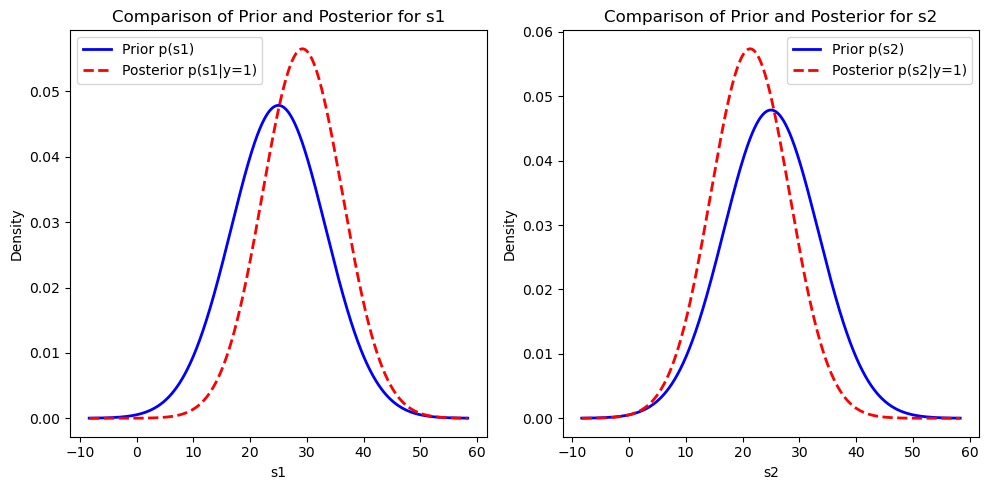

In [53]:
# Plot the prior and posterior for s1
x_s1 = np.linspace(mu_1 - 4*sigma_1, mu_1 + 4*sigma_1, 1000)
prior_s1 = norm.pdf(x_s1, mu_1, sigma_1)
posterior_s1 = norm.pdf(x_s1, mu_1_post, sigma_1_post)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x_s1, prior_s1, label="Prior p(s1)", color='blue', lw=2)
plt.plot(x_s1, posterior_s1, label="Posterior p(s1|y=1)", color='red', lw=2, linestyle='dashed')
plt.title("Comparison of Prior and Posterior for s1")
plt.xlabel("s1")
plt.ylabel("Density")
plt.legend()

# Plot the prior and posterior for s2
x_s2 = np.linspace(mu_2 - 4*sigma_2, mu_2 + 4*sigma_2, 1000)
prior_s2 = norm.pdf(x_s2, mu_2, sigma_2)
posterior_s2 = norm.pdf(x_s2, mu_2_post, sigma_2_post)

plt.subplot(1, 2, 2)
plt.plot(x_s2, prior_s2, label="Prior p(s2)", color='blue', lw=2)
plt.plot(x_s2, posterior_s2, label="Posterior p(s2|y=1)", color='red', lw=2, linestyle='dashed')
plt.title("Comparison of Prior and Posterior for s2")
plt.xlabel("s2")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

# Q5 - Assumed Density Filtering

## Loading Dataset

In [54]:
# Load the dataset
df = pd.read_csv(dataset_path)

## Preprocessing


In [55]:
if dataset_path == "Extension_data.csv":
    # Select columns and map 'FTR' values
    result_df = df.loc[:, ['HomeTeam', 'AwayTeam', 'FTR']].rename(columns={
        'HomeTeam': 'team1', 'AwayTeam': 'team2', 'FTR': 'game_outcome'
    })
    result_df['game_outcome'] = result_df['game_outcome'].map({'A': -1, 'H': 1, 'D': 0})
else:
    # Create score difference based on scores
    result_df = pd.DataFrame({
        'team1': df['team1'],
        'team2': df['team2'],
        'game_outcome': np.sign(df['score1'] - df['score2'])  # np.sign() simplifies score difference mapping
    })

Finding the name of the unique teams 

In [56]:
# Generate team mapping and add indices
unique_teams = pd.concat([result_df['team1'], result_df['team2']]).unique()
unique_teams.sort()
team_mapping = {team: i for i, team in enumerate(unique_teams)}

result_df['team1_idx'] = result_df['team1'].map(team_mapping)
result_df['team2_idx'] = result_df['team2'].map(team_mapping)
result_df

,team1,team2,game_outcome,team1_idx,team2_idx
0,Chievo,Juventus,-1,3,9
1,Lazio,Napoli,-1,10,12
2,Torino,Roma,-1,18,14
3,Sassuolo,Inter,1,16,8
4,Parma,Udinese,0,13,19
...,...,...,...,...,...
375,Roma,Parma,1,14,13
376,Inter,Empoli,1,8,4
377,Fiorentina,Genoa,0,5,7
378,Cagliari,Udinese,-1,2,19


Adding index columns to the dataset and makign new dataframe

In [57]:
# Filter out rows with zero score difference and convert to numpy
result_df = result_df[result_df['game_outcome'] != 0]
result_df = result_df[['team1_idx', 'team2_idx', 'game_outcome']]
result_array = result_df.to_numpy()

# Display the result DataFrame
result_df

,team1_idx,team2_idx,game_outcome
0,3,9,-1
1,10,12,-1
2,18,14,-1
3,16,8,1
5,4,2,1
...,...,...,...
374,17,11,-1
375,14,13,1
376,8,4,1
378,2,19,-1


In [58]:
def get_team_skills(team_A, team_B, skills_dist):
    # Extract mu and sigma for team_A and team_B
    mu_A, sigma_A = skills_dist[team_A]
    mu_B, sigma_B = skills_dist[team_B]
        
    return mu_A, sigma_A, mu_B, sigma_B

def set_team_skills(team_A, mu_A, sigma_A, team_B, mu_B, sigma_B, skills_dist):
    skills_dist[team_A] = [mu_A, sigma_A]
    skills_dist[team_B] = [mu_B, sigma_B]


update the skills based on each matches

In [59]:
# MU and Sigma for each team
skills_dist = [[mu_1, sigma_1] for _ in unique_teams]

for team_A, team_B, y in result_array:
    mu_A, sigma_A, mu_B, sigma_B = get_team_skills(team_A, team_B, skills_dist)
    samples = gibbs_sampler(mu_A, sigma_A, mu_B, sigma_B,
                                                    y=y,
                                                    iterations=iterations)
    # Getting the mean and variance of new skills
    mean = np.mean(samples[burn_in:, :2], axis = 0)
    covariance = np.cov(samples, rowvar = False)
    mu_A_new, sigma_A_new, mu_B_new, sigma_B_new =  mean[0], np.sqrt(covariance[0,0]), mean[1], np.sqrt(covariance[1, 1])
    set_team_skills(team_A, mu_A_new, sigma_A_new, team_B, mu_B_new, sigma_B_new, skills_dist)

## Q5.1
Final Ranking

In [60]:
# ranked based on mu - 3 * sigma
ranked_teams = sorted(enumerate(skills_dist), key=lambda x: x[1][0] - 3.0 * x[1][1], reverse=True)
# Print ranked teams with their skills
for rank, (idx, (m, s)) in enumerate(ranked_teams, start=1):
    print(f"Rank {rank}: Team {unique_teams[idx]} - Skill: {m}, Var: {s*s}")

Rank 1: Team Napoli - Skill: 29.74809675662844, Var: 2.1036426001538358
Rank 2: Team Atalanta - Skill: 28.385973317973505, Var: 1.6442589468147797
Rank 3: Team Inter - Skill: 28.302099728783304, Var: 1.7356155237147726
Rank 4: Team Juventus - Skill: 29.21499414535624, Var: 3.0448058128189
Rank 5: Team Milan - Skill: 28.878164395688405, Var: 2.7812845039650527
Rank 6: Team Torino - Skill: 28.01574495978072, Var: 2.3721883625591977
Rank 7: Team Roma - Skill: 26.977024435678278, Var: 1.8926843354470175
Rank 8: Team Lazio - Skill: 25.58735983257999, Var: 1.795272062552168
Rank 9: Team Sampdoria - Skill: 24.66916506060092, Var: 1.610201748695576
Rank 10: Team Bologna - Skill: 24.156673636902003, Var: 1.6444699061682913
Rank 11: Team Empoli - Skill: 23.948192176894388, Var: 1.6095396293700395
Rank 12: Team Spal - Skill: 23.862214974210602, Var: 1.7400474733045972
Rank 13: Team Parma - Skill: 23.453874082179894, Var: 1.4536904849298538
Rank 14: Team Udinese - Skill: 23.947378398945023, Var: 2

Q5.2 
Changing the order of matches.

In [61]:
np.random.seed(num_seeds)
np.random.shuffle(result_array)

In [62]:
# MU and Sigma for each team
skills_dist = [[mu_1, sigma_1] for _ in unique_teams]
skills_dist[0]

for team_A, team_B, y in result_array:
    mu_A, sigma_A, mu_B, sigma_B = get_team_skills(team_A, team_B, skills_dist)
    samples = gibbs_sampler(mu_A, sigma_A, mu_B, sigma_B,
                                                    y=y,
                                                    iterations=iterations)
    # Getting the mean and variance of new skills
    mean = np.mean(samples[burn_in:, :2], axis = 0)
    covariance = np.cov(samples, rowvar = False)
    mu_A_new, sigma_A_new, mu_B_new, sigma_B_new =  mean[0], np.sqrt(covariance[0,0]), mean[1], np.sqrt(covariance[1, 1])
    set_team_skills(team_A, mu_A_new, sigma_A_new, team_B, mu_B_new, sigma_B_new, skills_dist)

In [63]:
# ranked based on mu - 3 * sigma
ranked_teams = sorted(enumerate(skills_dist), key=lambda x: x[1][0] - 3.0 * x[1][1], reverse=True)
# Print ranked teams with their skills
for rank, (idx, (m, s)) in enumerate(ranked_teams, start=1):
    print(f"Rank {rank}: Team {unique_teams[idx]} - Skill: {m}, Var: {s*s}")

Rank 1: Team Napoli - Skill: 31.37495415234311, Var: 3.1961592365404616
Rank 2: Team Juventus - Skill: 30.273307045429327, Var: 2.6077036083633254
Rank 3: Team Milan - Skill: 28.990381381214128, Var: 1.9094744436718403
Rank 4: Team Torino - Skill: 28.958099022125182, Var: 2.3533880583823126
Rank 5: Team Atalanta - Skill: 27.92861509394406, Var: 1.6001700048009275
Rank 6: Team Roma - Skill: 28.169300744913542, Var: 1.9272543446045156
Rank 7: Team Inter - Skill: 27.844709233731876, Var: 1.9649326830635707
Rank 8: Team Lazio - Skill: 26.330423451063467, Var: 1.6184776389930446
Rank 9: Team Sampdoria - Skill: 25.699571561429114, Var: 1.472043413069686
Rank 10: Team Bologna - Skill: 25.32210187176285, Var: 1.6884271263608583
Rank 11: Team Empoli - Skill: 23.74909629017733, Var: 1.5320597562419562
Rank 12: Team Genoa - Skill: 24.32987770116692, Var: 2.11369222084507
Rank 13: Team Udinese - Skill: 23.864434200353386, Var: 1.7402211850406781
Rank 14: Team Cagliari - Skill: 23.842740637836418, 

# Q6 - Using the model for predictions

In [64]:
def phi_value(mu_A, sigma_A, mu_B, sigma_B, sigma_t=sigma_t):
   
    denom = np.sqrt(sigma_A * sigma_A + sigma_B * sigma_B + sigma_t * sigma_t)
    # Calculate the argument for the CDF (Phi)
    argument = (mu_B - mu_A) / denom
    return norm.cdf(argument)

def predict_winner(mu_A, sigma_A, mu_B, sigma_B):
    # 1 if A wins, -1 if lose.
    return 1 if 1 - phi_value(mu_A, sigma_A, mu_B, sigma_B) >= 0.5 else -1

In [65]:
predicted_y = []
# initializing MU and Sigma for each team
skills_dist = [[mu_1, sigma_1] for _ in unique_teams]

for team_A, team_B, y in result_array:
    mu_A, sigma_A, mu_B, sigma_B = get_team_skills(team_A, team_B, skills_dist)
    # compute the prediction
    predicted_y.append(predict_winner(mu_A, sigma_A, mu_B, sigma_B))
    samples = gibbs_sampler(mu_A, sigma_A, mu_B, sigma_B,
                                                    y=y,
                                                    iterations=iterations)
    # Getting the mean and variance of new skills
    mean = np.mean(samples[burn_in:, :2], axis = 0)
    covariance = np.cov(samples, rowvar = False)
    mu_A_new, sigma_A_new, mu_B_new, sigma_B_new =  mean[0], np.sqrt(covariance[0,0]), mean[1], np.sqrt(covariance[1, 1])
    set_team_skills(team_A, mu_A_new, sigma_A_new, team_B, mu_B_new, sigma_B_new, skills_dist)

# compare to the result in the dataset
true_y = result_array[:, -1]
correct_guesses = np.sum(predicted_y == true_y)
r = correct_guesses / len(true_y)
print(f"r is {r:.2f}")

r is 0.65


Ranking

In [66]:
# ranked based on mu - 3 * sigma
ranked_teams = sorted(enumerate(skills_dist), key=lambda x: x[1][0] - 3.0 * x[1][1], reverse=True)
# Print ranked teams with their skills
for rank, (idx, (m, s)) in enumerate(ranked_teams, start=1):
    print(f"Rank {rank}: Team {unique_teams[idx]} - Skill: {m}, Var: {s*s}")

Rank 1: Team Napoli - Skill: 31.04941591003155, Var: 1.9639293173071377
Rank 2: Team Juventus - Skill: 30.33823189747151, Var: 2.811956774488368
Rank 3: Team Milan - Skill: 29.129326313641684, Var: 1.8119209034812993
Rank 4: Team Torino - Skill: 28.37800589651712, Var: 1.5711257315315525
Rank 5: Team Atalanta - Skill: 28.078629584052766, Var: 1.530146841165419
Rank 6: Team Inter - Skill: 28.161922298087223, Var: 1.7404547508989123
Rank 7: Team Roma - Skill: 28.205083636144156, Var: 1.8287284479996837
Rank 8: Team Lazio - Skill: 26.409440761935095, Var: 1.9657968686325864
Rank 9: Team Sampdoria - Skill: 25.70770304044652, Var: 1.593721292902867
Rank 10: Team Bologna - Skill: 25.679306684072564, Var: 2.0536761994990225
Rank 11: Team Spal - Skill: 24.006032107247112, Var: 1.4251967832470371
Rank 12: Team Empoli - Skill: 23.771746723538413, Var: 1.3620642080328869
Rank 13: Team Udinese - Skill: 24.05056199373013, Var: 1.6406881833973632
Rank 14: Team Sassuolo - Skill: 24.399312622796653, V

# Q8 - A message-passing algorithm

Gussian interaction

In [67]:

def multiplyGauss(m1, s1, m2, s2):
    """
    Computes the Gaussian distribution N(m,s) proportional to N(m1,s1) * N(m2,s2)
    """
    s = 1 / (1 / s1 + 1 / s2)
    m = (m1 / s1 + m2 / s2) * s
    return m, s

def divideGauss(m1, s1, m2, s2):
    """
    Computes the Gaussian distribution N(m,s) proportional to N(m1,s1) / N(m2,s2)
    """
    m, s = multiplyGauss(m1, s1, m2, -s2)
    return m, s

def truncGaussMM(a, b, m0, s0):
    """
    Computes the mean and variance of a truncated Gaussian distribution
    """
    # Scale the interval with the mean and variance
    a_scaled, b_scaled = (a - m0) / np.sqrt(s0), (b - m0) / np.sqrt(s0)
    m = truncnorm.mean(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0))
    s = truncnorm.var(a_scaled, b_scaled, loc=m0, scale=np.sqrt(s0))
    return m, s

P(t|y) = P(y|t) . P(t)

In [68]:
def p_t(mu, sigma, t):
    return norm.pdf(t, loc=mu, scale=sigma)

def p_y_given_t(t, y_obs):
    if (y_obs == -1 and t < 0) or (y_obs == 1 and t > 0):
        return 1  # p(y | t ) = 1 based on your conditions
    else:
        return 0

# Function to calculate the combined probability
def p_t_given_y(mu, sigma, t, y_obs):
    return p_t(mu, sigma, t) * p_y_given_t(t, y_obs)

Moment Matching

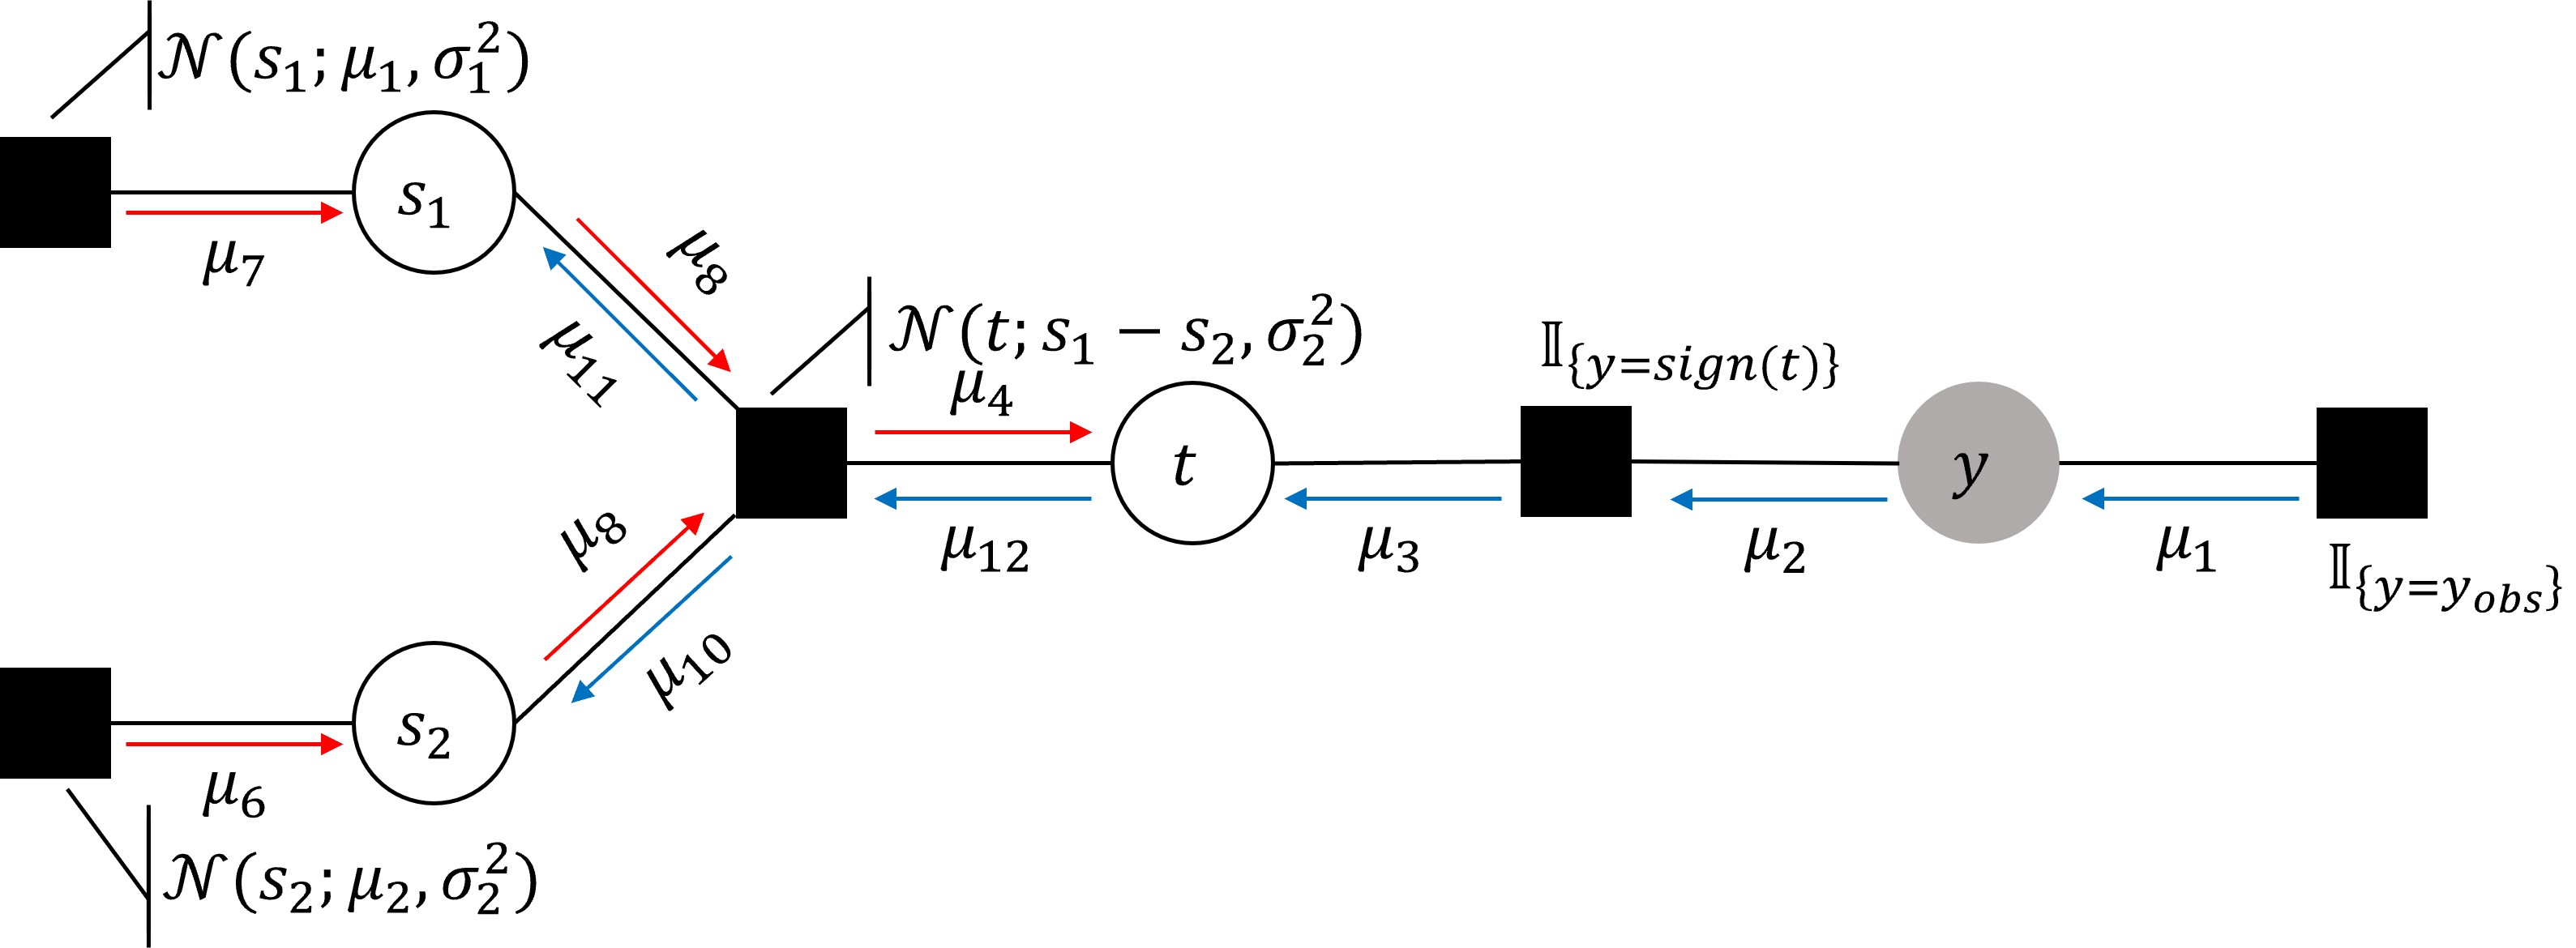

In [69]:
# Initialize S1, S2
mean_msg8 = mu_1  # Mean of mu8
var_msg8 = sigma_1 * sigma_1 # Variance of mu8

mean_msg5 = mu_2  # Mean of message mu5
var_msg5 = sigma_2 * sigma_2 # Variance of message

y = 1 # initial y

# Message 4 from factor f(t,s1,s2) to node t
mean_msg4 = mean_msg8 - mean_msg5 
var_msg4 = var_msg8 + var_msg5 + sigma_t * sigma_t

# Do moment matching of the marginal of t
if y == 1:
    a, b = 0, np.Inf
else:
    a, b = -np.Inf, 0

mean_p_t_given_y, var_p_t_given_y = truncGaussMM(a, b, mean_msg4, var_msg4)

# Compute the message from t to f(t, s1, s2)
mean_msg12, var_msg12 = divideGauss(mean_p_t_given_y, var_p_t_given_y, mean_msg4, var_msg4)

# Compute the message from f(t, s1, s2) to s1
mean_p_s1, var_p_s1 = multiplyGauss(mean_msg12 + mean_msg5, var_msg5 + var_msg12 + sigma_t * sigma_t, mean_msg8, var_msg8)

# Compute the message from f(t, s1, s2) to s2
mean_p_s2, var_p_s2 =  multiplyGauss(mean_msg8 - mean_msg12, var_msg8 + var_msg12 + sigma_t * sigma_t, mean_msg5, var_msg5)



# # Output result
print(f"> s1: mean:{mean_p_s1}, var:{var_p_s1}")  
print(f"> s2: mean:{mean_p_s2}, var:{var_p_s2}")  

> s1: mean:29.43269200446036, var:49.795686038037616
> s2: mean:20.567307995539636, var:49.795686038037616


In [70]:
# Moment Matching posterior parameters
mu_1_post_mm, sigma_1_post_mm = mean_p_s1, np.sqrt(var_p_s1)
mu_2_post_mm, sigma_2_post_mm = mean_p_s2, np.sqrt(var_p_s2)

Example execution of the sampler for y = 1

In [71]:
samples = gibbs_sampler(mu_1, sigma_1, mu_2, sigma_2, y=1, iterations=iterations)

# Extract s_1, s_2, and t samples
s_1_samples, s_2_samples, t_samples = samples[:, 0], samples[:, 1], samples[:, 2]
s_1_filtered = s_1_samples[burn_in:]
s_2_filtered = s_2_samples[burn_in:]

skills_filtered = np.column_stack((s_1_filtered, s_2_filtered))

print(samples.shape)
print(samples[0])

(1200, 3)
[13.94902491 17.67569479  1.34204906]


Gaussian Approximation

In [72]:
gaussian_dist = gaussian_approximation(skills_filtered)
print("Mean of the approximated Gaussian distribution:", gaussian_dist.mean)
print("Covariance matrix of the approximated Gaussian distribution:", gaussian_dist.cov)

Mean of the approximated Gaussian distribution: [29.46760533 20.29984704]
Covariance matrix of the approximated Gaussian distribution: [[48.70896665 19.35499238]
 [19.35499238 48.91977475]]


In [73]:
# Gibbs Sampling posterior parameters 
mu_1_post_gibbs, sigma_1_post_gibbs = gaussian_dist.mean[0], np.sqrt(gaussian_dist.cov[0][0])
mu_2_post_gibbs, sigma_2_post_gibbs = gaussian_dist.mean[1], np.sqrt(gaussian_dist.cov[1][1])

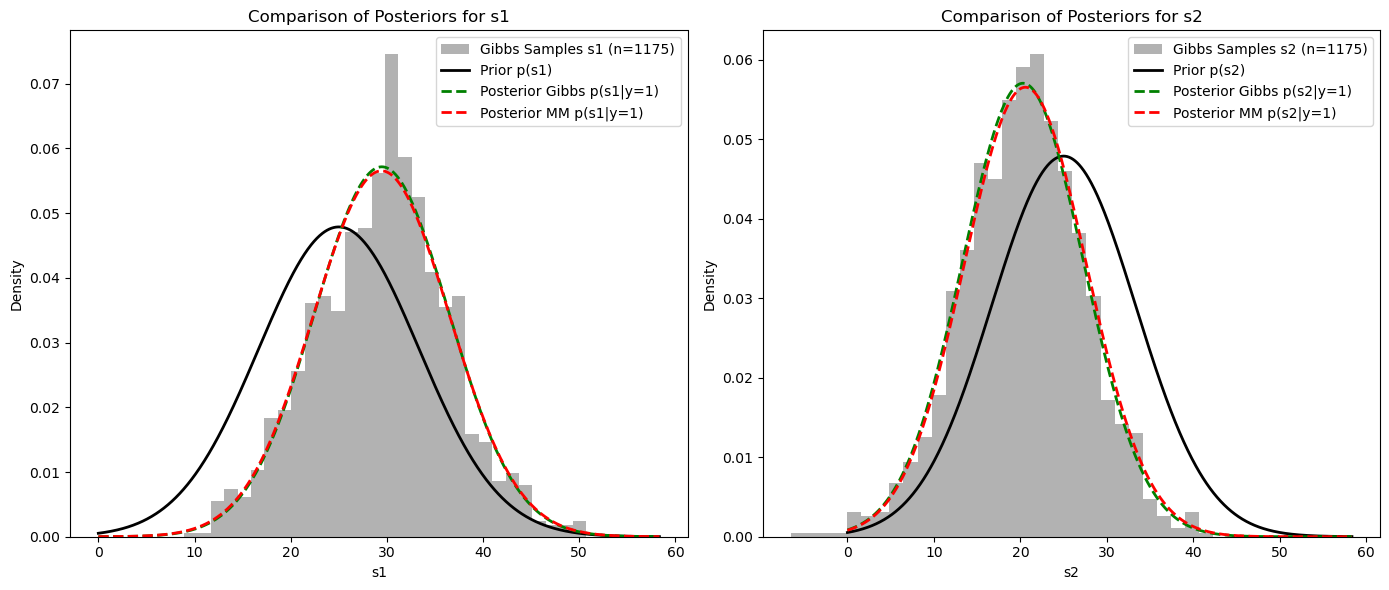

In [74]:
# Define x-axis range for s1 and s2 (non-negative starting at 0)
x_s1 = np.linspace(0, mu_1 + 4*sigma_1, 1000)
x_s2 = np.linspace(0, mu_2 + 4*sigma_2, 1000)

# Compute PDFs for priors and posteriors
prior_s1 = norm.pdf(x_s1, mu_1, sigma_1)
posterior_s1_mm = norm.pdf(x_s1, mu_1_post_mm, sigma_1_post_mm)
posterior_s1_gibbs = norm.pdf(x_s1, mu_1_post_gibbs, sigma_1_post_gibbs)

prior_s2 = norm.pdf(x_s2, mu_2, sigma_2)
posterior_s2_mm = norm.pdf(x_s2, mu_2_post_mm, sigma_2_post_mm)
posterior_s2_gibbs = norm.pdf(x_s2, mu_2_post_gibbs, sigma_2_post_gibbs)

num_samples = len(s_1_filtered)

# Anzahl der Samples nach dem Burn-in
num_samples = len(s_1_filtered)

# Plot histograms of the samples and Gaussian approximations for both s1 and s2
plt.figure(figsize=(14, 6))

# Plot for s1
plt.subplot(1, 2, 1)
plt.hist(s_1_filtered, bins=30, density=True, alpha=0.6, color='gray', label=f"Gibbs Samples s1 (n={num_samples})")
plt.plot(x_s1, prior_s1, label="Prior p(s1)", color='black', lw=2)  
plt.plot(x_s1, posterior_s1_gibbs, label="Posterior Gibbs p(s1|y=1)", color='green', lw=2, linestyle='dashed')  
plt.plot(x_s1, posterior_s1_mm, label="Posterior MM p(s1|y=1)", color='red', lw=2, linestyle='dashed')  
plt.title("Comparison of Posteriors for s1")
plt.xlabel("s1")
plt.ylabel("Density")
plt.legend()

# Plot for s2
plt.subplot(1, 2, 2)
plt.hist(s_2_filtered, bins=30, density=True, alpha=0.6, color='gray', label=f"Gibbs Samples s2 (n={num_samples})")
plt.plot(x_s2, prior_s2, label="Prior p(s2)", color='black', lw=2)  
plt.plot(x_s2, posterior_s2_gibbs, label="Posterior Gibbs p(s2|y=1)", color='green', lw=2, linestyle='dashed') 
plt.plot(x_s2, posterior_s2_mm, label="Posterior MM p(s2|y=1)", color='red', lw=2, linestyle='dashed') 
plt.title("Comparison of Posteriors for s2")
plt.xlabel("s2")
plt.ylabel("Density")
plt.legend()

plt.tight_layout()
plt.show()

# Q9 - Your own data

 Loading dataset

In [75]:
nba_df = pd.read_csv('nba.csv', nrows=500)

In [76]:
unique_nba_teams = pd.concat([nba_df['team1'], nba_df['team1']], ignore_index=True).unique().tolist() # list
unique_nba_teams.sort()
# Assign index to each
unique_nba_teams # 0, Celtics

['Blackhawks',
 'Bombers',
 'Bullets',
 'Capitols',
 'Celtics',
 'Hawks',
 'Knicks',
 'Lakers',
 'Nationals',
 'Nuggets',
 'Olympians',
 'Packers',
 'Pistons',
 'Redskins',
 'Royals',
 'Stags',
 'Warriors']

In [77]:
nba_team_mapping = {}
for i, team in enumerate(unique_nba_teams):
    nba_team_mapping[team] = i
nba_team_mapping # Celtics, 0

{'Blackhawks': 0,
 'Bombers': 1,
 'Bullets': 2,
 'Capitols': 3,
 'Celtics': 4,
 'Hawks': 5,
 'Knicks': 6,
 'Lakers': 7,
 'Nationals': 8,
 'Nuggets': 9,
 'Olympians': 10,
 'Packers': 11,
 'Pistons': 12,
 'Redskins': 13,
 'Royals': 14,
 'Stags': 15,
 'Warriors': 16}

Adding index columns to the dataset and makign new dataframe

In [78]:
# Adding index columns to the dataset
nba_df['team1_idx'] = nba_df['team1'].map(nba_team_mapping)
nba_df['team2_idx'] = nba_df['team2'].map(nba_team_mapping)


game_outcome = nba_df['team1_score'] - nba_df['team2_score']

# Create a new DataFrame with the desired columns
result_nba_df = pd.DataFrame({
    'team1_idx': nba_df['team1_idx'],
    'team2_idx': nba_df['team2_idx'],
    'game_outcome': np.where(nba_df['team1_score'] - nba_df['team2_score'] > 0, 1, 
                                   np.where(nba_df['team1_score'] - nba_df['team2_score'] < 0, -1, 0))
})

# Remove rows where game_outcome is zero
result_nba_df = result_nba_df[result_nba_df['game_outcome'] != 0]
# convert panda to numpy
nba_result_array = result_nba_df.to_numpy()
result_nba_df

,team1_idx,team2_idx,game_outcome
0,1,0,1
1,14,13,1
2,10,9,1
3,15,6,-1
4,3,2,1
...,...,...,...
495,6,7,-1
496,2,15,1
497,3,4,1
498,14,12,1


In [79]:
# MU and Sigma for each team
nba_skills_dist = [[mu_1, sigma_1] for _ in unique_nba_teams]
nba_skills_dist[0]

[25, 8.333333333333334]

In [80]:
for team_A, team_B, y in nba_result_array:
    mu_A, sigma_A, mu_B, sigma_B = get_team_skills(team_A, team_B, nba_skills_dist)
    samples = gibbs_sampler(mu_A, sigma_A, mu_B, sigma_B,
                                                    y=y,
                                                    iterations=iterations)
    # Getting the mean and variance of new skills
    mean = np.mean(samples[burn_in:, :2], axis = 0)
    covariance = np.cov(samples, rowvar = False)
    mu_A_new, sigma_A_new, mu_B_new, sigma_B_new =  mean[0], np.sqrt(covariance[0,0]), mean[1], np.sqrt(covariance[1, 1])
    set_team_skills(team_A, mu_A_new, sigma_A_new, team_B, mu_B_new, sigma_B_new, nba_skills_dist)

 Final Ranking

In [81]:
# ranked based on mu - 3 * sigma
ranked_nba_teams = sorted(enumerate(nba_skills_dist), key=lambda x: x[1][0] - 3.0 * x[1][1], reverse=True)
# Print ranked teams with their skills
for rank, (idx, (m, s)) in enumerate(ranked_nba_teams, start=1):
    print(f"Rank {rank}: Team {unique_nba_teams[idx]} - Skill: {m}, Var: {s*s}")

Rank 1: Team Lakers - Skill: 29.561653890914013, Var: 0.5096984494759699
Rank 2: Team Royals - Skill: 29.055953393896356, Var: 0.6138324109263934
Rank 3: Team Nationals - Skill: 28.578920070332426, Var: 0.8705301185803592
Rank 4: Team Knicks - Skill: 27.54874235618729, Var: 0.4650543713393958
Rank 5: Team Pistons - Skill: 27.27463431825471, Var: 0.5573153162029151
Rank 6: Team Stags - Skill: 27.068950380749236, Var: 0.6665506864892609
Rank 7: Team Olympians - Skill: 26.446647433295862, Var: 0.6132955124452647
Rank 8: Team Packers - Skill: 25.84156300253949, Var: 0.5159747076206244
Rank 9: Team Capitols - Skill: 25.735898577405575, Var: 0.505132122796552
Rank 10: Team Blackhawks - Skill: 25.95141612095738, Var: 0.6889481390879002
Rank 11: Team Bullets - Skill: 24.989443156285642, Var: 0.5314702637444585
Rank 12: Team Warriors - Skill: 24.829929137252257, Var: 0.6504667864283087
Rank 13: Team Celtics - Skill: 24.569418143423277, Var: 0.5625534657159648
Rank 14: Team Bombers - Skill: 24.9

Shuffling

In [82]:
np.random.seed(num_seeds)
np.random.shuffle(nba_result_array)

# MU and Sigma for each team
nba_skills_dist = [[mu_1, sigma_1] for _ in unique_nba_teams]
nba_skills_dist[0]

[25, 8.333333333333334]

In [83]:
for team_A, team_B, y in nba_result_array:
    mu_A, sigma_A, mu_B, sigma_B = get_team_skills(team_A, team_B, nba_skills_dist)
    samples = gibbs_sampler(mu_A, sigma_A, mu_B, sigma_B,
                                                    y=y,
                                                    iterations=iterations)
    # Getting the mean and variance of new skills
    mean = np.mean(samples[burn_in:, :2], axis = 0)
    covariance = np.cov(samples, rowvar = False)
    mu_A_new, sigma_A_new, mu_B_new, sigma_B_new =  mean[0], np.sqrt(covariance[0,0]), mean[1], np.sqrt(covariance[1, 1])
    set_team_skills(team_A, mu_A_new, sigma_A_new, team_B, mu_B_new, sigma_B_new, nba_skills_dist)

In [84]:
# ranked based on mu - 3 * sigma
ranked_nba_teams = sorted(enumerate(nba_skills_dist), key=lambda x: x[1][0] - 3.0 * x[1][1], reverse=True)
# Print ranked teams with their skills
for rank, (idx, (m, s)) in enumerate(ranked_nba_teams, start=1):
    print(f"Rank {rank}: Team {unique_nba_teams[idx]} - Skill: {m}, Var: {s*s}")

Rank 1: Team Lakers - Skill: 28.504425464085436, Var: 0.5712748391464411
Rank 2: Team Royals - Skill: 28.340500346442667, Var: 0.5866490536603796
Rank 3: Team Nationals - Skill: 27.64702689634968, Var: 0.7328003659343411
Rank 4: Team Stags - Skill: 26.60499183950763, Var: 0.7496776533054689
Rank 5: Team Pistons - Skill: 26.19420193720145, Var: 0.7667404289001077
Rank 6: Team Knicks - Skill: 26.126193852247255, Var: 0.8484536613203769
Rank 7: Team Capitols - Skill: 24.7217539746136, Var: 0.44334038304747336
Rank 8: Team Olympians - Skill: 25.302074245401712, Var: 0.9454332628661004
Rank 9: Team Warriors - Skill: 24.00529422389953, Var: 0.46533437091127566
Rank 10: Team Packers - Skill: 24.60384897084823, Var: 0.8895909870986308
Rank 11: Team Blackhawks - Skill: 24.093340068596437, Var: 0.744422408029599
Rank 12: Team Bullets - Skill: 23.472190221349194, Var: 0.5189174498432807
Rank 13: Team Bombers - Skill: 23.659757005405044, Var: 0.6965145478285518
Rank 14: Team Celtics - Skill: 23.50

# Q10

## Loading and preprocessing dataset

In [85]:
# Load the dataset
df = pd.read_csv(dataset_path)
if dataset_path == "Extension_data.csv":
    # Select columns and map 'FTR' values
    result_df = df.loc[:, ['HomeTeam', 'AwayTeam', 'FTR']].rename(columns={
        'HomeTeam': 'team1', 'AwayTeam': 'team2', 'FTR': 'game_outcome'
    })
    result_df['game_outcome'] = result_df['game_outcome'].map({'A': -1, 'H': 1, 'D': 0})
else:
    # Create score difference based on scores
    result_df = pd.DataFrame({
        'team1': df['team1'],
        'team2': df['team2'],
        'game_outcome': np.sign(df['score1'] - df['score2'])  # np.sign() simplifies score difference mapping
    })
# Generate team mapping and add indices
unique_teams = pd.concat([result_df['team1'], result_df['team2']]).unique()
team_mapping = {team: i for i, team in enumerate(sorted(unique_teams))}

result_df['team1_idx'] = result_df['team1'].map(team_mapping)
result_df['team2_idx'] = result_df['team2'].map(team_mapping)
# convert to numpy
result_df = result_df[['team1_idx', 'team2_idx', 'game_outcome']]
result_array = result_df.to_numpy()
result_df

,team1_idx,team2_idx,game_outcome
0,3,9,-1
1,10,12,-1
2,18,14,-1
3,16,8,1
4,13,19,0
...,...,...,...
375,14,13,1
376,8,4,1
377,5,7,0
378,2,19,-1


## Considering Draws

In [86]:
# Gibbs Sampler
def gibbs_sampler_with_draws(mu_A, sigma_A, mu_B, sigma_B ,y, iterations, epsilon):
    
    if y == 1:
        t = np.abs(np.random.randn())
    elif y == -1:
        t = -np.abs(np.random.randn())
    else:
        if mu_A >= mu_B:
            t = np.random.uniform(0, epsilon)
        elif mu_A < mu_B:
            t = - np.random.uniform(0, epsilon)
        
        

    samples = []
    
    for i in range(iterations):
        # Calculationg mean and sigma of p(s1,s2|t,y) = p(S|t,y)
        
        sigma_s_inv = np.array([[1.0/(sigma_A * sigma_A), 0.0],
                                [0.0, 1.0/(sigma_B * sigma_B)]])
        
        sigma_t_given_s_inv = 1.0 / (sigma_t * sigma_t)
        mu_s = np.array([mu_A, mu_B]).T.reshape(2,1) # 2 x 1 (2, 1)
        A = np.array([1.0, -1.0]).reshape(1, 2) # 1 x 2
        
        # (2x2)
        cov_s_given_t = np.linalg.inv(sigma_s_inv + (A.T @ (sigma_t_given_s_inv * A) ) )
        
        # (2x1)
        mean_s_given_t = cov_s_given_t @ ( (sigma_s_inv @ mu_s) + (A.T * sigma_t_given_s_inv * t) )
 
       
        
        mean_s_given_t = mean_s_given_t.reshape(2,)
        # QUESTION 3.1
        # Step 1: Draw s_1 and s_2 from the conditional distribution N(mean_s|t, cov_s|t) -
        s_1, s_2 = multivariate_normal.rvs(mean=mean_s_given_t, cov=cov_s_given_t)

        

        # QUESTION 3.2
        # Step 2: Draw t from the conditional distribution 
        mean_t = s_1 - s_2 

        if y == 1:
            t = truncated_normal(mean_t, sigma_t, epsilon, np.inf)  # For y = 1, t > e
        elif y == -1:
            t = truncated_normal(mean_t, sigma_t, -np.inf, -epsilon)  # For y = -1, t < e
        else:
            if mu_A >= mu_B:
                t = truncated_normal(mean_t, sigma_t, 0, epsilon) # For y = 0, t < e
            elif mu_A < mu_B:
                t = truncated_normal(mean_t, sigma_t, -epsilon, 0)
            

        # Store samples
        samples.append((s_1, s_2, t))

    
  
    samples = np.array(samples)
    return samples

In [87]:
def phi_value(mu_A, sigma_A, mu_B, sigma_B, sigma_t=sigma_t):
   
    denom = np.sqrt(sigma_A * sigma_A + sigma_B * sigma_B + sigma_t * sigma_t)
    # Calculate the argument for the CDF (Phi)
    argument = (mu_B - mu_A) / denom
    return norm.cdf(argument)

def predict_winner_with_draws(epsilon, mu_A, sigma_A, mu_B, sigma_B):
    p_win = 1 - phi_value(mu_A, sigma_A, mu_B, sigma_B) 
    if p_win >= 0.5 + epsilon:
        return 1 # win
    elif p_win <= 0.5 - epsilon:
        return -1 # lost
    return 0 # draw

In [88]:
predicted_y = []
limit = len(result_array)

# MU and Sigma for each team
skills_dist = [[mu_1, sigma_1] for _ in unique_teams]
skills_dist[0]

for team_A, team_B, y in result_array[:limit]:
    mu_A, sigma_A, mu_B, sigma_B = get_team_skills(team_A, team_B, skills_dist)
    # compute the prediction
    predicted_y.append(predict_winner_with_draws(predict_epsilon, mu_A, sigma_A, mu_B, sigma_B))
    samples = gibbs_sampler_with_draws(mu_A, sigma_A, mu_B, sigma_B,
                                                    y=y,
                                                    iterations=iterations,
                                                    epsilon=t_epsilon)
    # Getting the mean and variance of new skills
    mean = np.mean(samples[burn_in:, :2], axis = 0)
    covariance = np.cov(samples, rowvar = False)
    mu_A_new, sigma_A_new, mu_B_new, sigma_B_new =  mean[0], np.sqrt(covariance[0,0]), mean[1], np.sqrt(covariance[1, 1])
    set_team_skills(team_A, mu_A_new, sigma_A_new, team_B, mu_B_new, sigma_B_new, skills_dist)

# compare to the result in the dataset
true_y = result_array[:, -1]
correct_guesses = np.sum(predicted_y == true_y[:limit])
r = correct_guesses / limit
print(f"r is {r:.2f}")

r is 0.49


In [89]:
print(predicted_y[:20])
print(true_y[:20])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, -1, 0, 1, -1, 0, -1, 0]
[-1 -1 -1  1  0  1 -1  1  1  1  1  1  0  1  0  1  0  0  1 -1]


In [90]:
# ranked based on mu - 3 * sigma
ranked_teams = sorted(enumerate(skills_dist), key=lambda x: x[1][0] - 3.0 * x[1][1], reverse=True)
# Print ranked teams with their skills
for rank, (idx, (m, s)) in enumerate(ranked_teams, start=1):
    print(f"Rank {rank}: Team {unique_teams[idx]} - Skill: {m}, Var: {s*s}")

Rank 1: Team Napoli - Skill: 28.949613221556255, Var: 1.4860871134228475
Rank 2: Team Inter - Skill: 27.987613496303055, Var: 0.8348135652988997
Rank 3: Team Chievo - Skill: 27.454300932128493, Var: 0.6440658059326225
Rank 4: Team Udinese - Skill: 27.25913610063785, Var: 0.8585049243305496
Rank 5: Team Juventus - Skill: 27.39418098130681, Var: 0.9850992190103666
Rank 6: Team Frosinone - Skill: 27.224090247736076, Var: 1.0482860242054377
Rank 7: Team Milan - Skill: 26.869970002984967, Var: 0.8733911574742016
Rank 8: Team Spal - Skill: 25.8445703176372, Var: 0.8539538551531377
Rank 9: Team Fiorentina - Skill: 25.320001141862264, Var: 0.765284313777001
Rank 10: Team Cagliari - Skill: 24.773750951411603, Var: 0.6078173329767903
Rank 11: Team Empoli - Skill: 24.477920395673028, Var: 0.6396615894089664
Rank 12: Team Lazio - Skill: 24.561074678136084, Var: 0.8330829234724031
Rank 13: Team Atalanta - Skill: 24.070295557844364, Var: 0.6599883915523925
Rank 14: Team Sampdoria - Skill: 24.2372321